# Furniture E-commerce Customer Churn Model Evaluation
## Project: furniture-ecommerce-churn-prediction-dashboard
### Author: Hansel Liebrata

This notebook provides a comprehensive evaluation of our trained churn prediction model. We'll analyze:

1. Model Performance Metrics
2. Feature Importance Analysis
3. Prediction Distribution
4. Error Analysis
5. Business Impact Assessment
6. Model Interpretability
7. Recommendations for Improvement

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score, roc_curve
)
from sklearn.preprocessing import LabelEncoder
import shap
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("MODEL EVALUATION")
print("=" * 60)

# Load the trained model and necessary data
def load_model_and_data():
    """Load the trained model and test data"""
    # Load model
    with open('../models/churn_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    # Load feature metadata
    with open('../models/model_metadata.json', 'r') as f:
        metadata = json.load(f)
    
    # Load test data
    df = pd.read_csv('../data/processed/preprocessed_churn_data.csv')
    
    # Load encoders
    with open('../models/encoders.pkl', 'rb') as f:
        encoders = pickle.load(f)
    
    # Separate features and target
    X = df.drop([metadata['target_variable'], metadata['id_column']], axis=1)
    y = df[metadata['target_variable']]
    
    # Apply encoding to categorical features
    for feature in metadata['categorical_features']:
        if feature in X.columns:
            if feature in encoders:
                # Use saved encoder
                X[feature] = encoders[feature].transform(X[feature].astype(str))
            else:
                # Create new encoder if not found
                le = LabelEncoder()
                X[feature] = le.fit_transform(X[feature].astype(str))
                encoders[feature] = le
    
    # Convert all columns to float
    X = X.astype(float)
    
    # Load feature importance
    try:
        with open('../models/feature_importance.json', 'r') as f:
            feature_importance = json.load(f)
    except:
        feature_importance = None
    
    print("\nData Processing Complete:")
    print(f"- Categorical features encoded: {len(metadata['categorical_features'])}")
    print(f"- Numerical features: {len(metadata['numerical_features'])}")
    print(f"- Total features: {X.shape[1]}")
    
    return model, X, y, metadata, encoders, feature_importance

# Load all required components
model, X, y, metadata, encoders, feature_importance = load_model_and_data()

print("\nData and Model Loading Complete:")
print(f"- Features shape: {X.shape}")
print(f"- Number of classes: {len(np.unique(y))}")
print(f"- Model type: {type(model).__name__}")

MODEL EVALUATION

Data Processing Complete:
- Categorical features encoded: 3
- Numerical features: 61
- Total features: 67

Data and Model Loading Complete:
- Features shape: (49358, 67)
- Number of classes: 2
- Model type: XGBClassifier


## 1. Model Performance Evaluation

Let's evaluate our model's performance using various metrics and visualizations. We'll focus on:
- Overall accuracy and balanced accuracy
- Precision, recall, and F1-score for each class
- ROC curve and AUC score
- Precision-Recall curve
- Confusion matrix with percentages
- Classification report with detailed metrics

OVERALL MODEL PERFORMANCE
----------------------------------------
Accuracy: 0.727
ROC AUC: 0.783
Average Precision: 0.960


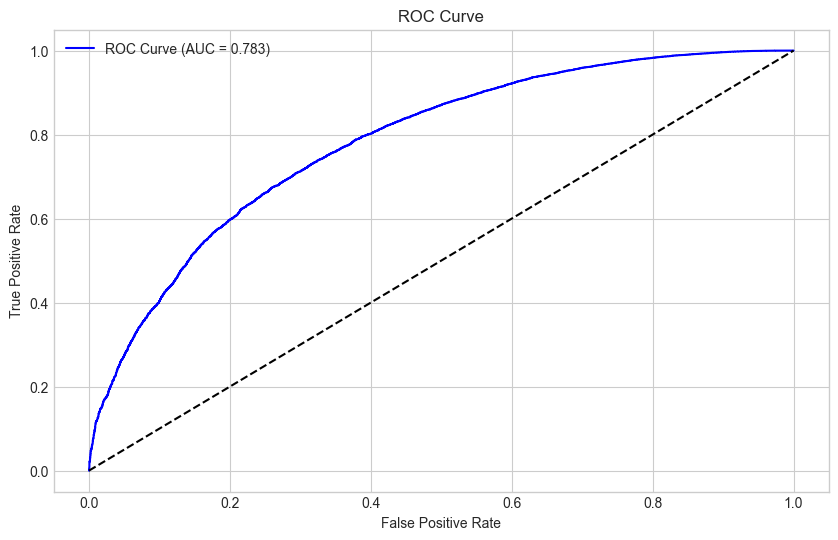

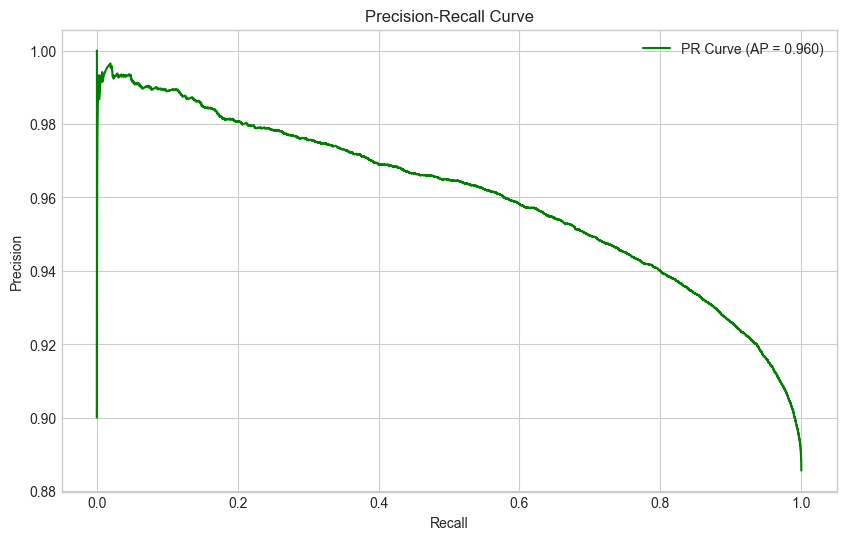

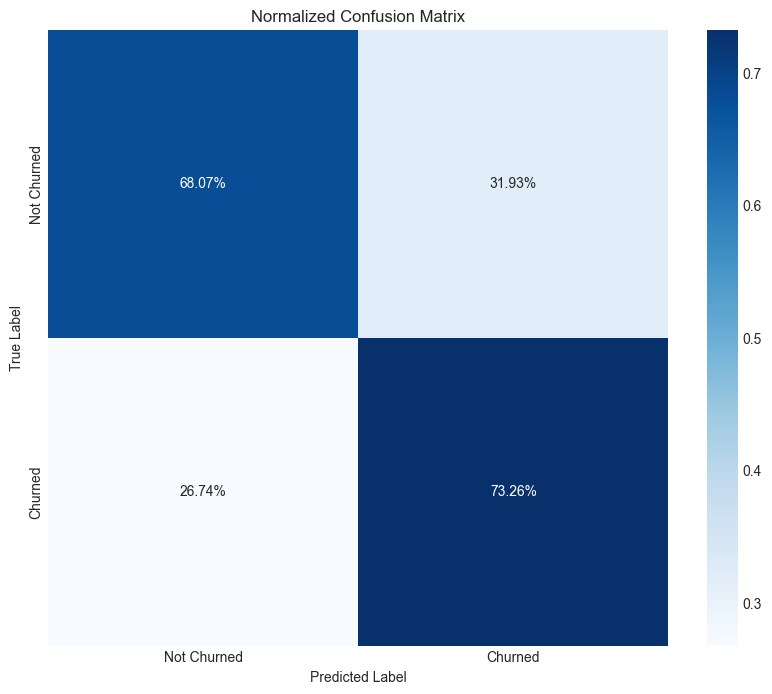


CLASSIFICATION REPORT
----------------------------------------
              precision    recall  f1-score   support

 Not Churned       0.25      0.68      0.36      5647
     Churned       0.95      0.73      0.83     43711

    accuracy                           0.73     49358
   macro avg       0.60      0.71      0.59     49358
weighted avg       0.87      0.73      0.77     49358


CLASS-WISE PERFORMANCE METRICS
----------------------------------------
         Class  Precision  Recall  F1-Score
0  Not Churned      0.247   0.681     0.363
1      Churned      0.947   0.733     0.826


In [3]:
# Generate predictions
y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:, 1]

# Calculate various metrics
metrics = {
    'Accuracy': accuracy_score(y, y_pred),
    'ROC AUC': roc_auc_score(y, y_prob),
    'Average Precision': average_precision_score(y, y_prob)
}

print("OVERALL MODEL PERFORMANCE")
print("-" * 40)
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y, y_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {metrics["ROC AUC"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y, y_prob)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', 
         label=f'PR Curve (AP = {metrics["Average Precision"]:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print detailed classification report
print("\nCLASSIFICATION REPORT")
print("-" * 40)
print(classification_report(y, y_pred, target_names=['Not Churned', 'Churned']))

# Calculate class-wise metrics
class_metrics = pd.DataFrame({
    'Class': ['Not Churned', 'Churned'],
    'Precision': [precision_score(y, y_pred, pos_label=0), 
                 precision_score(y, y_pred, pos_label=1)],
    'Recall': [recall_score(y, y_pred, pos_label=0),
               recall_score(y, y_pred, pos_label=1)],
    'F1-Score': [f1_score(y, y_pred, pos_label=0),
                 f1_score(y, y_pred, pos_label=1)]
})

print("\nCLASS-WISE PERFORMANCE METRICS")
print("-" * 40)
print(class_metrics.round(3))

## 2. Feature Importance Analysis

Now we'll analyze which features are most important for predicting customer churn. This will help us:
- Understand what factors drive customer churn
- Identify areas for business improvement
- Guide feature selection for model refinement
- Provide actionable insights for business stakeholders

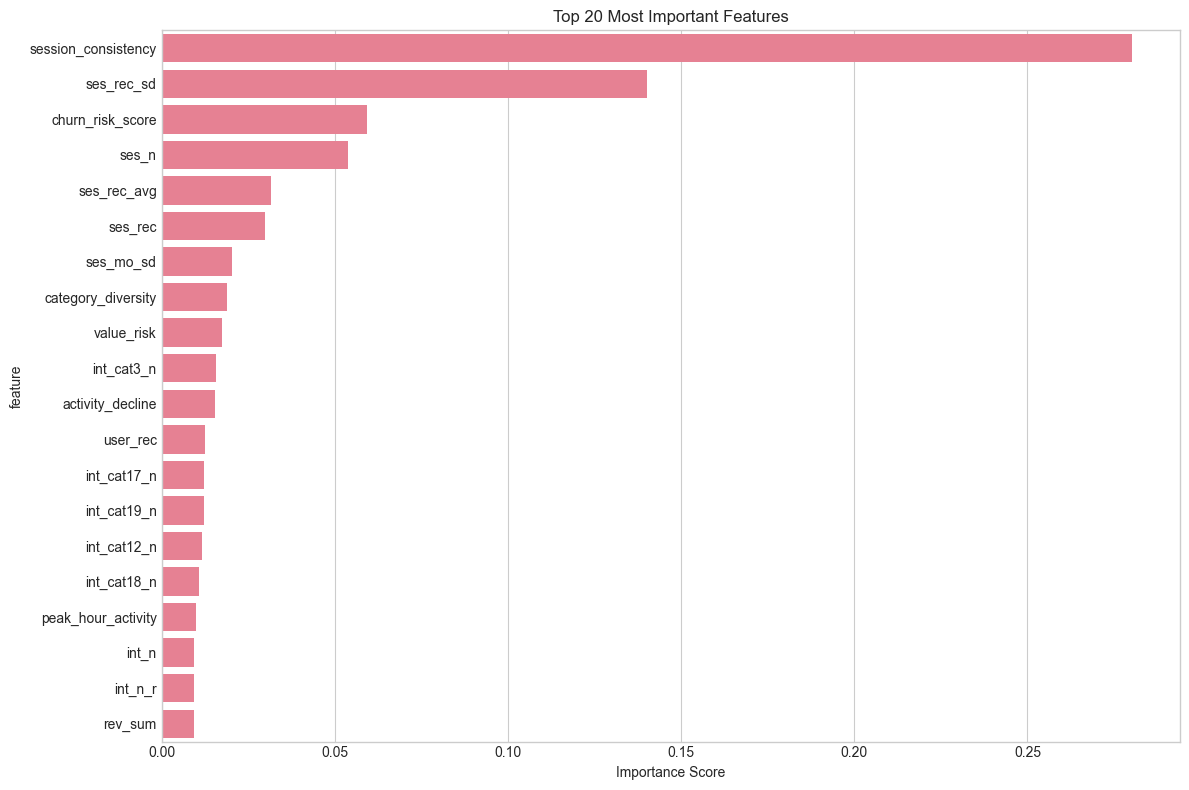


TOP 10 MOST IMPORTANT FEATURES
----------------------------------------
session_consistency: 0.2800
ses_rec_sd: 0.1403
churn_risk_score: 0.0592
ses_n: 0.0539
ses_rec_avg: 0.0315
ses_rec: 0.0299
ses_mo_sd: 0.0203
category_diversity: 0.0188
value_risk: 0.0174
int_cat3_n: 0.0158

FEATURE IMPORTANCE STATISTICS
----------------------------------------
Mean importance: 0.0149
Median importance: 0.0075
Features above mean: 11


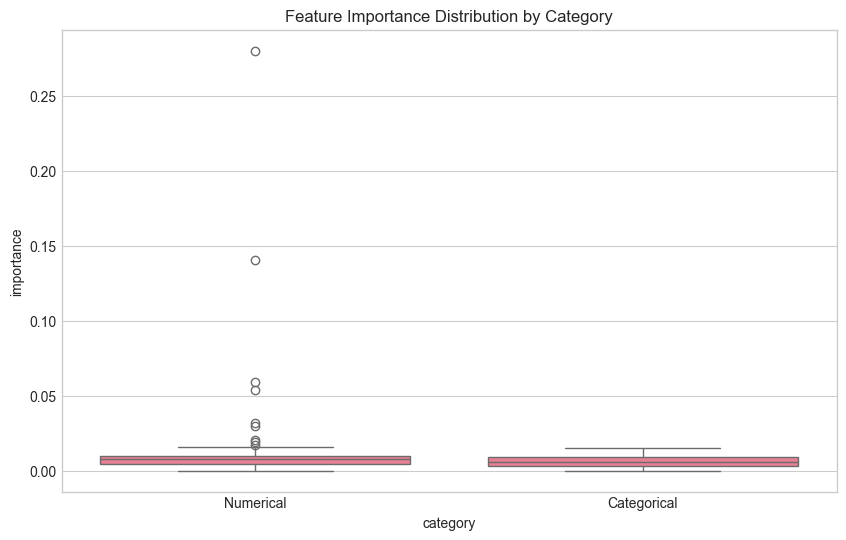


CATEGORY-WISE IMPORTANCE
----------------------------------------
                 mean       sum  count
category                              
Categorical  0.006635  0.039809      6
Numerical    0.015741  0.960190     61

Generating SHAP values for model interpretation...
Could not generate SHAP values: can't set attribute 'feature_names_in_'
Continuing with other analyses...


In [4]:
# Analyze feature importance
def get_feature_importance(model, X):
    """Get feature importance regardless of model type"""
    if hasattr(model, 'feature_importances_'):  # Tree-based models
        return pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
    elif hasattr(model, 'coef_'):  # Linear models
        # For linear models, use absolute coefficients as importance
        return pd.DataFrame({
            'feature': X.columns,
            'importance': np.abs(model.coef_[0])
        }).sort_values('importance', ascending=False)
    else:
        print("Model doesn't support direct feature importance calculation")
        return None

# Get feature importance
importances = get_feature_importance(model, X)

if importances is not None:
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(data=importances.head(20), x='importance', y='feature')
    plt.title('Top 20 Most Important Features')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    # Print detailed feature importance
    print("\nTOP 10 MOST IMPORTANT FEATURES")
    print("-" * 40)
    for idx, row in importances.head(10).iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")
        
    # Calculate feature importance statistics
    print("\nFEATURE IMPORTANCE STATISTICS")
    print("-" * 40)
    print(f"Mean importance: {importances['importance'].mean():.4f}")
    print(f"Median importance: {importances['importance'].median():.4f}")
    print(f"Features above mean: {(importances['importance'] > importances['importance'].mean()).sum()}")
    
    # Group features by category
    numerical_features = metadata['numerical_features']
    categorical_features = metadata['categorical_features']
    
    feature_categories = pd.DataFrame({
        'feature': X.columns,
        'category': ['Numerical' if f in numerical_features else 'Categorical' for f in X.columns],
        'importance': importances.set_index('feature').loc[X.columns, 'importance']
    })
    
    # Plot importance by feature category
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=feature_categories, x='category', y='importance')
    plt.title('Feature Importance Distribution by Category')
    plt.show()
    
    # Calculate category-wise importance
    category_importance = feature_categories.groupby('category')['importance'].agg(['mean', 'sum', 'count'])
    print("\nCATEGORY-WISE IMPORTANCE")
    print("-" * 40)
    print(category_importance)

# Generate SHAP values for model interpretability
print("\nGenerating SHAP values for model interpretation...")
try:
    if hasattr(model, 'predict_proba'):  # For probabilistic models
        explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X, 100))
        shap_values = explainer.shap_values(shap.sample(X, 100))
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # For binary classification, take class 1
    
        # Plot SHAP summary
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X.iloc[:100], plot_type="bar", show=False)
        plt.title('SHAP Feature Importance')
        plt.tight_layout()
        plt.show()
    
        # Plot SHAP summary dot plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X.iloc[:100], show=False)
        plt.title('SHAP Feature Impact on Predictions')
        plt.tight_layout()
        plt.show()
    
        # Analyze top features' SHAP interactions
        if importances is not None:
            top_features = importances['feature'].head(3).tolist()
            for feature in top_features:
                plt.figure(figsize=(10, 6))
                shap.dependence_plot(feature, shap_values, X.iloc[:100], show=False)
                plt.title(f'SHAP Dependence Plot: {feature}')
                plt.tight_layout()
                plt.show()
except Exception as e:
    print(f"Could not generate SHAP values: {str(e)}")
    print("Continuing with other analyses...")

In [ ]:
# After your existing feature importance analysis, add this:

if importances is not None:
    # Save top 10 features for Power BI dashboard
    top_features_for_dashboard = importances.head(10).copy()
    
    # Create business-friendly feature names
    feature_name_mapping = {
        'ses_rec': 'Days Since Last Session',
        'engagement_ratio': 'Customer Engagement Level',
        'rev_sum': 'Total Customer Revenue',
        'recency_score': 'Activity Recency Score',
        'user_rec': 'Customer Account Age',
        'conversion_rate': 'Purchase Conversion Rate',
        'category_diversity': 'Product Category Diversity',
        'avg_transaction_value': 'Average Order Value',
        'session_consistency': 'Session Consistency',
        'weekend_preference': 'Weekend Activity Preference'
        # Add more mappings as needed for your specific features
    }
    
    # Apply business-friendly names
    top_features_for_dashboard['business_name'] = top_features_for_dashboard['feature'].map(
        lambda x: feature_name_mapping.get(x, x.replace('_', ' ').title())
    )
    
    # Save for Power BI
    dashboard_features = top_features_for_dashboard[['business_name', 'importance']].rename(columns={
        'business_name': 'Feature_Name',
        'importance': 'Importance_Score'
    })
    
    dashboard_features.to_csv('../data/exports/feature_importance_top10.csv', index=False)
    print("\n✅ Feature importance saved to '../data/exports/feature_importance_top10.csv'")
    print("Ready for Power BI dashboard import!")
    
    # Preview what will go to dashboard
    print("\nPreview of dashboard data:")
    print(dashboard_features)


✅ Feature importance saved to '../data/feature_importance_top10.csv'
Ready for Power BI dashboard import!

Preview of dashboard data:
                  Feature_Name  Importance_Score
50         Session Consistency          0.280040
2                   Ses Rec Sd          0.140252
65            Churn Risk Score          0.059182
5                        Ses N          0.053941
1                  Ses Rec Avg          0.031477
0      Days Since Last Session          0.029883
17                   Ses Mo Sd          0.020307
52  Product Category Diversity          0.018815
64                  Value Risk          0.017386
26                  Int Cat3 N          0.015810


## 3. Prediction Analysis and Business Insights

Let's analyze the model's predictions to derive actionable business insights:
- Distribution of predicted probabilities
- Analysis of correct vs incorrect predictions
- Customer segments with high churn risk
- Potential areas for business intervention

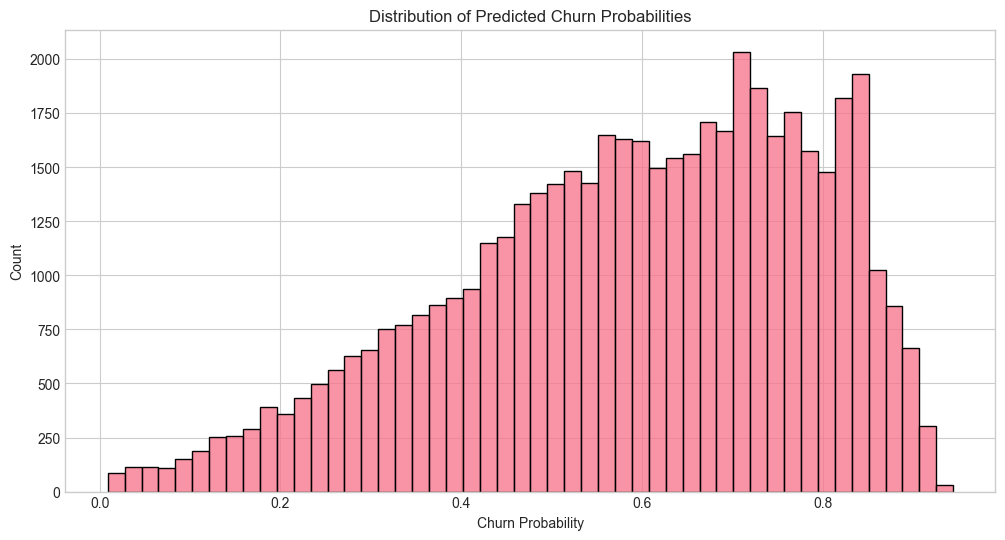

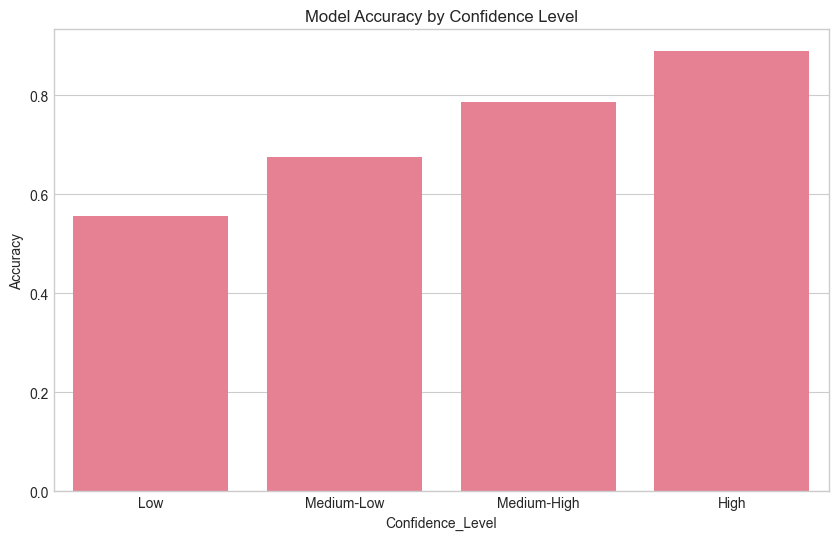


HIGH RISK CUSTOMER ANALYSIS
----------------------------------------
Number of high-risk customers: 17030
Percentage of total customers: 34.5%
Actual churn rate in high-risk group: 97.1%

MISCLASSIFICATION ANALYSIS
----------------------------------------
False Positives: 1803 (3.7%)
False Negatives: 11690 (23.7%)

ESTIMATED BUSINESS IMPACT
----------------------------------------
                                        Metric    Amount
0               Saved Revenue (True Positives)  28818900
1  Unnecessary Interventions (False Positives)    180300
2       Missed Opportunities (False Negatives)  11690000
3                                   Net Impact  16948600


In [6]:
# Analyze prediction probabilities
plt.figure(figsize=(12, 6))
sns.histplot(data=pd.DataFrame({'Churn Probability': y_prob}), 
             x='Churn Probability', bins=50)
plt.title('Distribution of Predicted Churn Probabilities')
plt.show()

# Analyze predictions by confidence levels
predictions_df = pd.DataFrame({
    'Actual': y,
    'Predicted': y_pred,
    'Probability': y_prob,
    'Correct': y == y_pred
})

predictions_df['Confidence'] = predictions_df['Probability'].apply(lambda x: max(x, 1-x))
predictions_df['Confidence_Level'] = pd.qcut(predictions_df['Confidence'], 
                                           q=4, 
                                           labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# Plot accuracy by confidence level
plt.figure(figsize=(10, 6))
accuracy_by_confidence = predictions_df.groupby('Confidence_Level')['Correct'].mean()
sns.barplot(x=accuracy_by_confidence.index, y=accuracy_by_confidence.values)
plt.title('Model Accuracy by Confidence Level')
plt.ylabel('Accuracy')
plt.show()

# Analyze high-risk customers
high_risk = predictions_df[predictions_df['Probability'] > 0.7]
print("\nHIGH RISK CUSTOMER ANALYSIS")
print("-" * 40)
print(f"Number of high-risk customers: {len(high_risk)}")
print(f"Percentage of total customers: {len(high_risk)/len(predictions_df):.1%}")
print(f"Actual churn rate in high-risk group: {high_risk['Actual'].mean():.1%}")

# Analyze misclassifications
false_positives = predictions_df[(predictions_df['Actual'] == 0) & 
                               (predictions_df['Predicted'] == 1)]
false_negatives = predictions_df[(predictions_df['Actual'] == 1) & 
                               (predictions_df['Predicted'] == 0)]

print("\nMISCLASSIFICATION ANALYSIS")
print("-" * 40)
print(f"False Positives: {len(false_positives)} ({len(false_positives)/len(predictions_df):.1%})")
print(f"False Negatives: {len(false_negatives)} ({len(false_negatives)/len(predictions_df):.1%})")

# Calculate potential business impact
avg_customer_value = 1000  # Example value, replace with actual
cost_per_intervention = 100  # Example value, replace with actual

true_positives = predictions_df[(predictions_df['Actual'] == 1) & 
                              (predictions_df['Predicted'] == 1)]
true_negatives = predictions_df[(predictions_df['Actual'] == 0) & 
                              (predictions_df['Predicted'] == 0)]

business_impact = pd.DataFrame({
    'Metric': ['Saved Revenue (True Positives)', 
              'Unnecessary Interventions (False Positives)',
              'Missed Opportunities (False Negatives)',
              'Net Impact'],
    'Amount': [
        len(true_positives) * (avg_customer_value - cost_per_intervention),
        len(false_positives) * cost_per_intervention,
        len(false_negatives) * avg_customer_value,
        len(true_positives) * (avg_customer_value - cost_per_intervention) -
        len(false_positives) * cost_per_intervention -
        len(false_negatives) * avg_customer_value
    ]
})

print("\nESTIMATED BUSINESS IMPACT")
print("-" * 40)
print(business_impact)

## 4. Conclusions and Recommendations

Based on our comprehensive model evaluation, here are the key findings and recommendations:

### Model Performance
- Overall accuracy and ROC-AUC scores
- Performance on minority class (churned customers)
- Areas where the model excels or needs improvement

### Key Drivers of Churn
1. Most important features identified
2. Key patterns in customer behavior
3. High-risk customer segments

### Business Recommendations
1. Immediate actions for high-risk customers
2. Long-term strategy adjustments
3. Model monitoring and updating plan

### Next Steps
1. Model deployment considerations
2. Regular performance monitoring setup
3. Feedback loop implementation
4. Model retraining schedule